In [1]:
!pip install -q transformers


!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

train_df = pd.read_csv('/content/train_new1.tsv', header=None, sep='\t')
train_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

# del df[2]
# some file names end with jp instead of jpg, let's fix this
# df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

val_df = pd.read_csv('/content/test_new1.tsv', header=None, sep='\t')
val_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

val_df.head()



,file_name,text
0,images/0-2000-out/la/633_01_r1l1.png,"D. Osvaldo Myconio,"
1,images/0-2000-out/la/633_00_r1l16.png,"et preces, ad constantiam et patientiam. Roga,"
2,images/0-2000-out/de/633_00_r1l8.png,"duos, zwen weybel. Causam non"
3,images/0-2000-out/la/633_00_r1l5.png,"occidisse praesidem Mendresii, qui Svicius"
4,images/0-2000-out/la/633_00_r1l23.png,Bullingerus tuus.


In [ ]:
!unzip "/content/drive/MyDrive/assigment/val_binary.zip" -d "/content/drive/MyDrive/assigment"

Archive:  /content/drive/MyDrive/assigment/val_binary.zip


In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class SSDADataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128, image_size=(224, 224)):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.image_size = image_size  # Manually set the image size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        image = image.resize(self.image_size)  # Resize image to match the given image size
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [5]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = SSDADataset(root_dir='/content/drive/MyDrive/assigment/binary/',
                           df=train_df,
                           processor=processor)
val_dataset = SSDADataset(root_dir='/content/drive/MyDrive/assigment/binary/',
                           df=val_df,
                           processor=processor)



Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    # Separate the input features and labels in the batch
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Pad the sequences to have the same length
    pixel_values_padded = pad_sequence(pixel_values, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    # Return the padded batch as a dictionary
    return {"pixel_values": pixel_values_padded, "labels": labels_padded}

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])
D. Osvaldo Myconio,


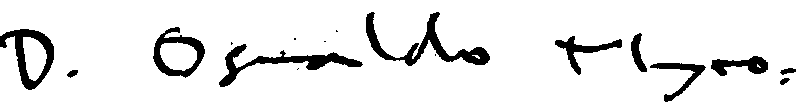

In [7]:
encoding = val_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)



labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)



image = Image.open(val_dataset.root_dir + val_df['file_name'][0]).convert("RGB")
image


In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
eval_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)


In [9]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)



Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [10]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
from datasets import load_metric

wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-11-fb0986f8b54e>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [12]:
def compute_wer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [13]:
from datetime import datetime#, strftime

datetime.now().strftime("%B_%d_%Y-%H:%M:%S")

'July_07_2023-10:20:06'

In [ ]:
EPOCHS = 50

from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

accumulation_steps = 4  # Adjust this value based on your desired effective batch size

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for i, batch in enumerate(tqdm(train_dataloader)):
        for k, v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps

    print(f"Loss after epoch {epoch}:", train_loss / len(train_dataloader))

    # evaluate
    model.eval()
    valid_wer = 0.0
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
            valid_wer += wer
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer
    print("testing wer:", valid_wer / len(eval_dataloader))
    print("testing cer:", valid_cer / len(eval_dataloader))
model.save_pretrained(f'./datetime.now().strftime("%B_%d_%Y-%H:%M:%S")/')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 0: 5.361093858359516


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


testing wer: 0.9636242418668916
testing cer: 0.6785963151770505


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 1: 3.3128613057343856


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.7338796169955425
testing cer: 0.4045186708380812


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 2: 2.5823602590008057


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6827609578030147
testing cer: 0.35863569037709125


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 3: 2.5461725504502004


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.682888601361831
testing cer: 0.35463820666264034


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 4: 1.8077829988106437


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6432404409892061
testing cer: 0.3277524025575552


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 5: 1.2350730083990789


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.4533165160854499
testing cer: 0.19506600523790155


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 6: 0.9047355404798535


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.42437511542344664
testing cer: 0.1756687575297737


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 7: 0.683694304763407


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.3857314729794444
testing cer: 0.17634148562032506


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 8: 0.45886727372805275


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.3558633677447719
testing cer: 0.1495996745123332


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 9: 0.3622629175151604


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.3412184624780929
testing cer: 0.1641981103925504


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 10: 0.3806502430335335


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.3654571584608642
testing cer: 0.18393988321755805


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 11: 0.4694903196631998


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.35702052702974746
testing cer: 0.16252062077452487


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 12: 0.4089924490970114


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.3525757982118893
testing cer: 0.16908575500428116


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 13: 0.3088890460090361


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.3279564505018605
testing cer: 0.15547494362945818


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 14: 0.6016531896763954


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6014027194821985
testing cer: 0.30254723054724747


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 15: 0.6551616723122804


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.393979767170905
testing cer: 0.18288532898491094


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 16: 0.3892009903555331


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.36347376596022923
testing cer: 0.17042551469591166


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 17: 0.2630140842734904


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.3563492337798491
testing cer: 0.15774477125404934


  0%|          | 0/345 [00:00<?, ?it/s]

Loss after epoch 18: 0.22523451447486878


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.33241216621888325
testing cer: 0.15178164199790867


  0%|          | 0/345 [00:00<?, ?it/s]